# Sentiment Analysis of Tweets about Brands (Apple & Google)

### Problem statement


This notebook builds an NLP model to classify sentiment in tweets directed at Apple and Google products.  


### Libraries

In [11]:
# pandas: for data handling
import pandas as pd

# re: Python's built-in library for regular expressions (used for text cleaning)
import re

# nltk: Natural Language Toolkit, useful for tokenization, stopword removal, and lemmatization
import nltk

import matplotlib.pyplot as plt

import seaborn as sns
nltk.download("punkt")        # tokenizer model

nltk.download("punkt_tab")    # sentence boundary detection

nltk.download("wordnet")      # lexical database for lemmatization 

nltk.download("omw-1.4")      # WordNet data for multiple languages

nltk.download("stopwords")    # common words to filter out (e.g., "the", "is")

# Import stopwords list from nltk (words to ignore during analysis)
from nltk.corpus import stopwords

# Import tokenizer to split text into individual words
from nltk.tokenize import word_tokenize

# Import lemmatizer to reduce words to their base form (e.g., "running" → "run")
from nltk.stem import WordNetLemmatizer

# TfidfVectorizer: convert text data into numerical features using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# train_test_split: split data into training and testing sets for model evaluation
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading Data

In [12]:
# Reading the CSV file with correct encoding
df = pd.read_csv('Data\judge-1377884607_tweet_product_company.csv', encoding='Latin-1')

# Displaying the first 5 rows of the dataset
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Exploratory Data Analysis (EDA)

- In order to better understand the dataset and prepare it for sentiment analysis, we will focus on the following checks:
    - Preview the data: Inspect the first few rows to quickly grasp the dataset’s structure.
    - Detect any missing values in the data that could introduce bias or cause issues during preprocessing and modeling.
    - Identify and remove duplicate tweets to prevent overrepresentation of certain entries, which could distort the sentiment model.
    - Review the balance of sentiment categories, since skewed classes may result in models that favor majority classes and perform poorly on minority ones.

In [13]:
#shape of the data set
df.shape

(9093, 3)

In [14]:
# Basic information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


#### Handling Missing Values


In [15]:
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

#### Duplicates

In [16]:
# Checking for duplicates and print how many there are
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows (excluding first occurrence): {num_duplicates}")

# Showing all rows that are duplicated, including their first occurrence
duplicates_with_originals = df[df.duplicated(keep=False)]

# Sorting so duplicates appear next to each other
duplicates_with_originals = duplicates_with_originals.sort_values(by=list(df.columns))

print("\nAll duplicate rows (including originals):")
duplicates_with_originals


Number of duplicate rows (excluding first occurrence): 22

All duplicate rows (including originals):


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
3962,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
466,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
2559,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
774,Google to Launch Major New Social Network Call...,NaN,No emotion toward brand or product
776,Google to Launch Major New Social Network Call...,NaN,No emotion toward brand or product
17,I just noticed DST is coming this weekend. How...,iPhone,Negative emotion
8483,I just noticed DST is coming this weekend. How...,iPhone,Negative emotion


### Basic Dataset Exploration

#### Sentiment Distribution

In [17]:
# Get sentiment counts
sentiment_counts = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()
sentiment_counts

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

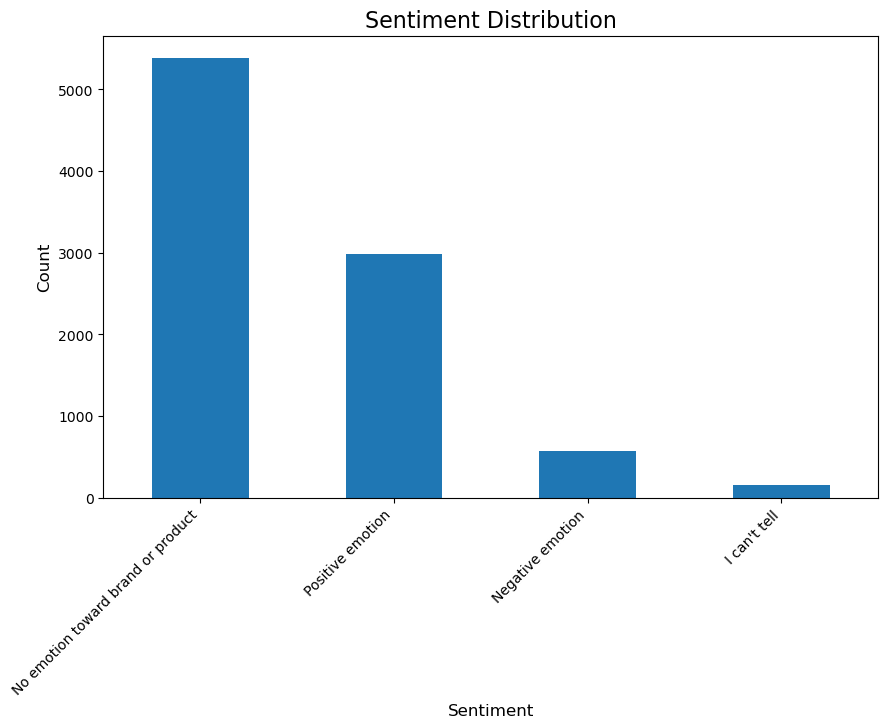

In [18]:
# Bar chart
plt.figure(figsize=(10,6))
sentiment_counts.plot(kind='bar')

plt.title("Sentiment Distribution", fontsize=16)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()


- Class imbalance exists, with Neutral (No-emotion) or positive emotion dominating and Negative being underrepresented.
    - The largest class is Neutral (No emotion toward brand or product) (5,375 tweets, ~54%).
    - The second largest is "Positive emotion" (2,970 tweets, ~30%).
    - "Negative emotion" is much smaller (569 tweets, ~6%).
    - "I can't tell" is very rare (156 tweets, ~2%).


#### Sentiment by Brand

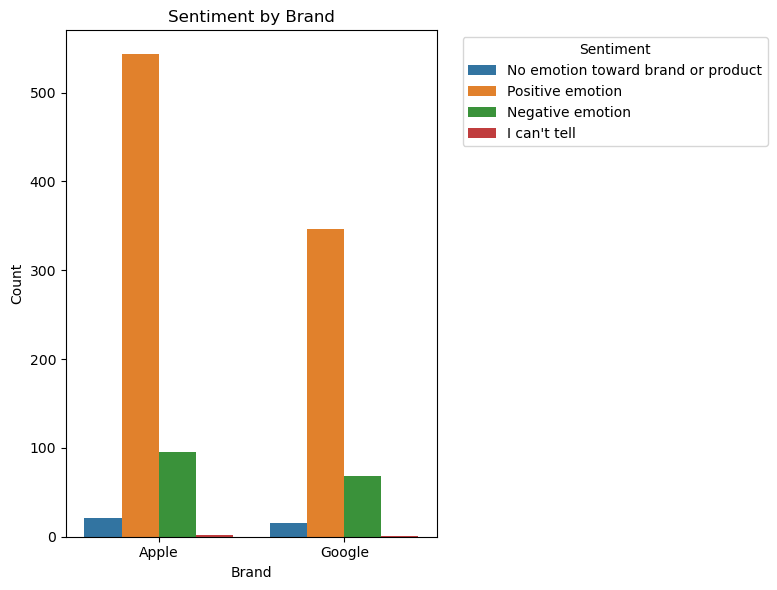

In [19]:
brands = ['Apple', 'Google']  # adjust if other brand names
subset = df[df['emotion_in_tweet_is_directed_at'].isin(brands)].copy()

plt.figure(figsize=(8,6))
hue_order = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts().index.tolist()
sns.countplot(data=subset, x='emotion_in_tweet_is_directed_at', hue='is_there_an_emotion_directed_at_a_brand_or_product',
              order=brands, hue_order=hue_order)
plt.title('Sentiment by Brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
# plt.savefig('sentiment_by_brand.png', bbox_inches='tight')
plt.show()


- People on Twitter generally express clear opinions, mostly positive, when talking about these brands.
     - Public sentiment is mostly positive for both brands, with Apple slightly leading in volume.
    - Negative sentiment exists but is much smaller, and neutral/ambiguous tweets are rare.


### Building a Custom Text Preprocessing Pipeline

- We aim to prepare tweets for machine learning, and to do this in a consistent and reproducible way, we use a Pipeline that applies the same cleaning and feature extraction steps to all tweets while keeping the process organized and reusable

- To achieve this, we will:
   - Clean and standardize text by removing noisy elements like URLs, mentions, hashtags, and special characters, then simplify the words through tokenization, stopword removal, and lemmatization.
   - Extract useful signals by capturing not only the words themselves (using TF-IDF) but also numeric properties of the tweets such as length, word diversity, and counts of mentions.
   - Add sentiment features using a sentiment analyzer to generate positive, negative, neutral, and overall (compound) scores.
   - Scale and combine everything by merging TF-IDF features with numeric and sentiment features into one standardized feature matrix that represents each tweet in structured numerical form.

- By following this process, we:
   - Turn raw tweets into structured data, where every tweet is represented numerically and ready for machine learning.
   - Capture both content and style – features reflect not only what is said (the meaning of the words) but also how it is said (length, sentiment, mentions, hashtags)
   - Creates a solid foundation for training accurate machine learning models.


In [ ]:
import pandas as pd
import re
import nltk
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Download NLTK resources (leave commented if already downloaded)
# nltk.download("punkt")
# nltk.download("stopwords")
# nltk.download("wordnet")
# nltk.download("omw-1.4")
# nltk.download("vader_lexicon")

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()

# -------------------------------
# Custom Preprocessor
# -------------------------------
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column

    def clean_text(self, text):
        text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # remove urls
        text = re.sub(r"@\w+", "", text)  # remove mentions
        text = re.sub(r"#\w+", "", text)  # remove hashtags
        text = re.sub(r"[^A-Za-z\s]", "", text)  # remove special characters
        return text.strip()
    
    def tokenize_lemmatize(self, text):
        tokens = word_tokenize(text)
        tokens = [t for t in tokens if t.lower() not in stop_words]
        tokens = [lemmatizer.lemmatize(t.lower()) for t in tokens]
        return " ".join(tokens)
    
    def transform(self, X, y=None):
        X_filled = X.copy()
        # Only process text, do not drop/fill missing values here
        X_filled[self.text_column] = X_filled[self.text_column].astype(str).apply(
            lambda t: self.tokenize_lemmatize(self.clean_text(t))
        )
        # Ensure no rows are dropped or filtered
        return X_filled

    def fit(self, X, y=None):
        return self

# -------------------------------
# Feature Engineering Transformer
# -------------------------------
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column

    def transform(self, X, y=None):
        df = X.copy()
        text_data = df[self.text_column].fillna("")

        # Numeric features
        features = pd.DataFrame({
            "tweet_length": text_data.apply(len),
            "word_count": text_data.apply(lambda t: len(t.split())),
            "avg_word_len": text_data.apply(lambda t: (sum(len(w) for w in t.split()) / (len(t.split()) + 1e-6))),
            "unique_word_ratio": text_data.apply(lambda t: len(set(t.split())) / (len(t.split()) + 1e-6)),
            "num_mentions": text_data.apply(lambda t: len(re.findall(r"@\w+", t))),
            "num_hashtags": text_data.apply(lambda t: len(re.findall(r"#\w+", t))),
        }, index=df.index)   # 🔑 Keep same index

        # Sentiment scores
        sentiment = text_data.apply(lambda t: sia.polarity_scores(t))
        sentiment_df = pd.DataFrame(list(sentiment), index=df.index)  # 🔑 align with df index

        # Concatenate safely
        return pd.concat([features, sentiment_df], axis=1).to_numpy()

    def fit(self, X, y=None):
        return self

# -------------------------------
# Load Dataset
# -------------------------------
df = pd.read_csv("Data/judge-1377884607_tweet_product_company.csv", encoding="Latin-1")

# Clean DataFrame before pipeline: drop missing and duplicate tweet_text
df_cleaned = df.dropna(subset=["tweet_text"]).drop_duplicates(subset=["tweet_text"])
df_cleaned["emotion_in_tweet_is_directed_at"] = df_cleaned["emotion_in_tweet_is_directed_at"].fillna("Unknown")

# Apply text preprocessing to get processed text
text_preprocessor = TextPreprocessor(text_column="tweet_text")
df_processed = text_preprocessor.transform(df_cleaned)

# Drop rows where processed tweet_text is empty after cleaning
df_final = df_processed[df_processed["tweet_text"].str.strip() != ""]

# -------------------------------
# Final Pipeline: Text + Numeric Features
# -------------------------------
preprocessing_pipeline = Pipeline([
    ("text_preprocessor", TextPreprocessor(text_column="tweet_text")),
    ("features", FeatureUnion(transformer_list=[
        # TF-IDF text representation
        ("tfidf", Pipeline([
            ("to_text", FunctionTransformer(lambda d: d["tweet_text"], validate=False)),
            ("tfidf", TfidfVectorizer(max_features=5000))
        ])),
        # Numeric engineered features
        ("engineered", Pipeline([
            ("eng", FeatureEngineer(text_column="tweet_text")),
            ("scaler", StandardScaler())
        ]))
    ]))
])

# Apply pipeline to fully cleaned DataFrame
X_features = preprocessing_pipeline.fit_transform(df_final)
print("Final feature matrix shape:", X_features.shape)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...


Final feature matrix shape: (9063, 5010)


In [ ]:
import numpy as np

# -------------------------------
# Inspect Pipeline Outputs
# -------------------------------

# 1. Get TF-IDF feature names
tfidf_vectorizer = preprocessing_pipeline.named_steps["features"].transformer_list[0][1].named_steps["tfidf"]
tfidf_features = tfidf_vectorizer.get_feature_names_out()

# 2. Define engineered feature names
engineered_feature_names = [
    "tweet_length", "word_count", "avg_word_len", "unique_word_ratio",
    "num_mentions", "num_hashtags", "sent_compound", "sent_pos", "sent_neu", "sent_neg"
]

# 3. Combine all feature names
all_feature_names = np.concatenate([tfidf_features, engineered_feature_names])

print("Total features:", len(all_feature_names))
print("First 20 features:", all_feature_names[:20])  # peek

# 4. Turn the transformed feature matrix into a DataFrame for inspection
X_features_df = pd.DataFrame(X_features.toarray() if hasattr(X_features, "toarray") else X_features,
                             columns=all_feature_names)

# Preview first rows
X_features_df.head()


Total features: 5010
First 20 features: ['aapl' 'aaron' 'ab' 'abacus' 'abandoned' 'abba' 'abc' 'aber' 'ability'
 'able' 'abnormal' 'abound' 'aboutto' 'abroad' 'absolute' 'absolutely'
 'absolutley' 'abt' 'abuzz' 'academy']
   aapl  aaron   ab  abacus  abandoned  abba  abc  aber  ability  able  ...  \
0   0.0    0.0  0.0     0.0        0.0   0.0  0.0   0.0      0.0   0.0  ...   
1   0.0    0.0  0.0     0.0        0.0   0.0  0.0   0.0      0.0   0.0  ...   
2   0.0    0.0  0.0     0.0        0.0   0.0  0.0   0.0      0.0   0.0  ...   
3   0.0    0.0  0.0     0.0        0.0   0.0  0.0   0.0      0.0   0.0  ...   
4   0.0    0.0  0.0     0.0        0.0   0.0  0.0   0.0      0.0   0.0  ...   

   tweet_length  word_count  avg_word_len  unique_word_ratio  num_mentions  \
0     -0.280400   -0.166396     -0.330289           0.428206           0.0   
1      1.125059    0.785653      0.709426           0.428207           0.0   
2     -2.170499   -2.070493     -1.464524           0.428202         

- We transformed the Tweets into a structured dataset that can be used for machine learning.
- Text features (TF-IDF): Each unique word in the dataset is turned into a numeric column that reflects how important that word is in each tweet.
- In addition to words, we created extra columns that describe each tweet’s properties, such as length, number of words, hashtags, mentions, and sentiment scores (positive, negative, neutral).
- The result is a single table where each row represents a tweet and each column represents either a word or one of these engineered features. These numeric features are the input our model will use to learn patterns and classify sentiment.

- We generated visual summaries to better understand the features extracted from Tweets:
    - Bar chart highlights the 20 most important words across all Tweets, based on how frequently and distinctively they appear.
    - Distribution plots showing how each extra feature (like tweet length, word count, hashtags, mentions, sentiment scores) varies across the dataset.
    - Heatmap shows correlations between these engineered features, helping us see which ones are related (e.g., longer tweets often have more words).

C:\Users\user\AppData\Local\Temp\ipykernel_30108\2302166391.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_terms, x="tfidf", y="term", palette="viridis")


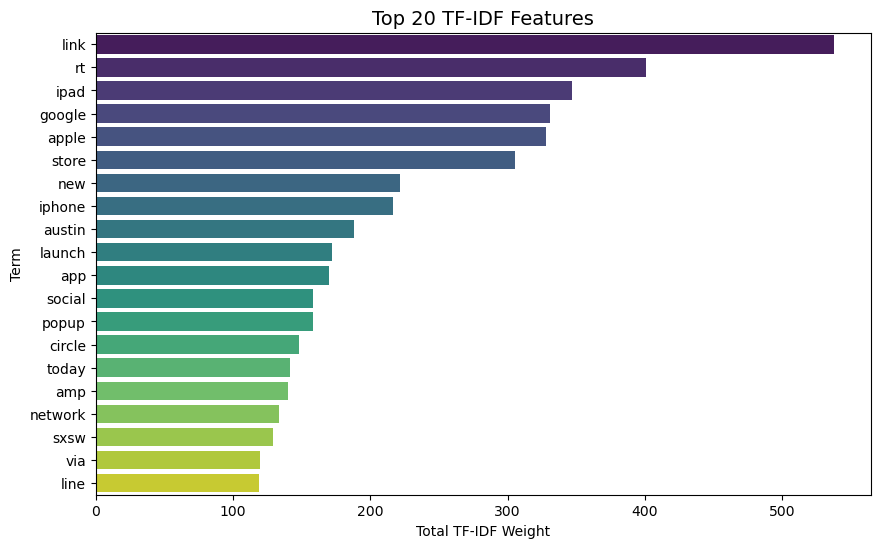

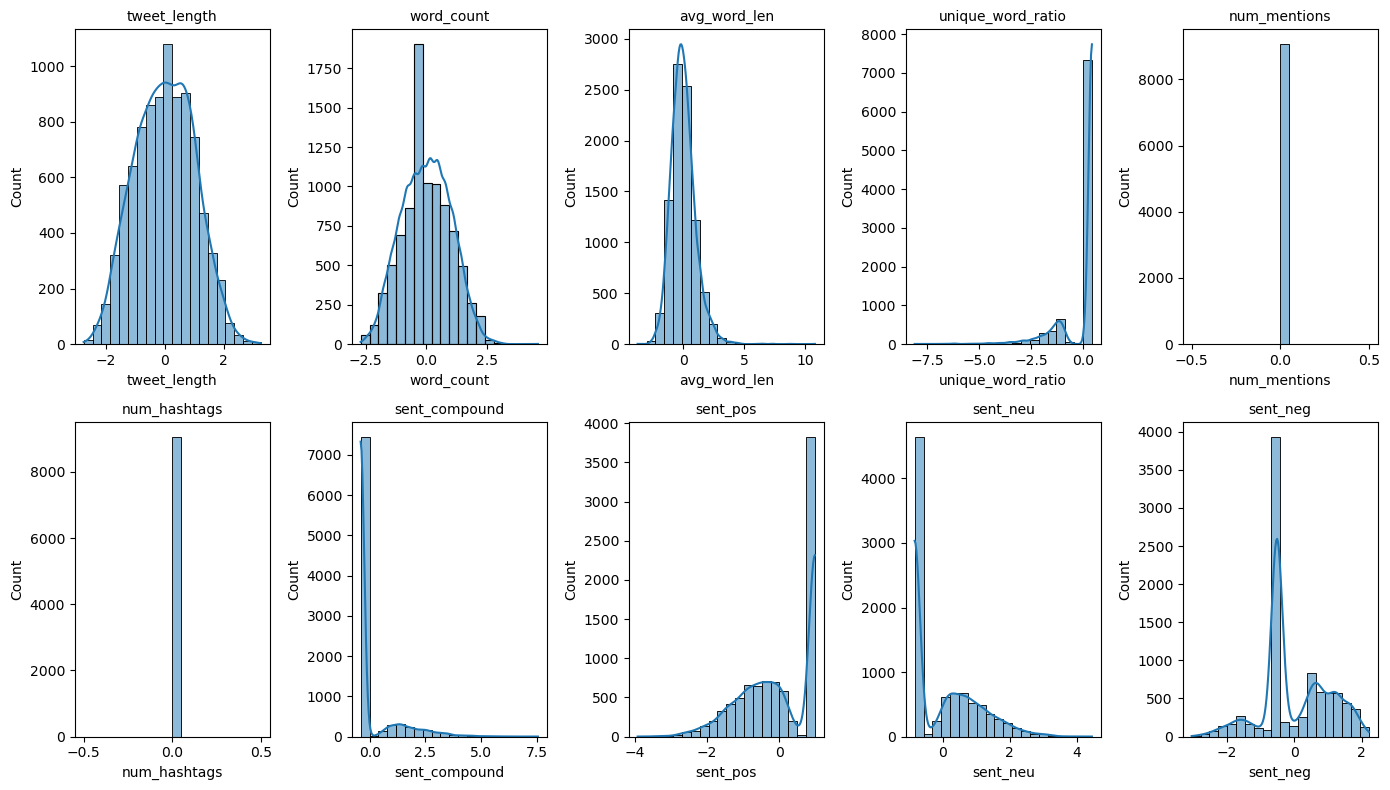

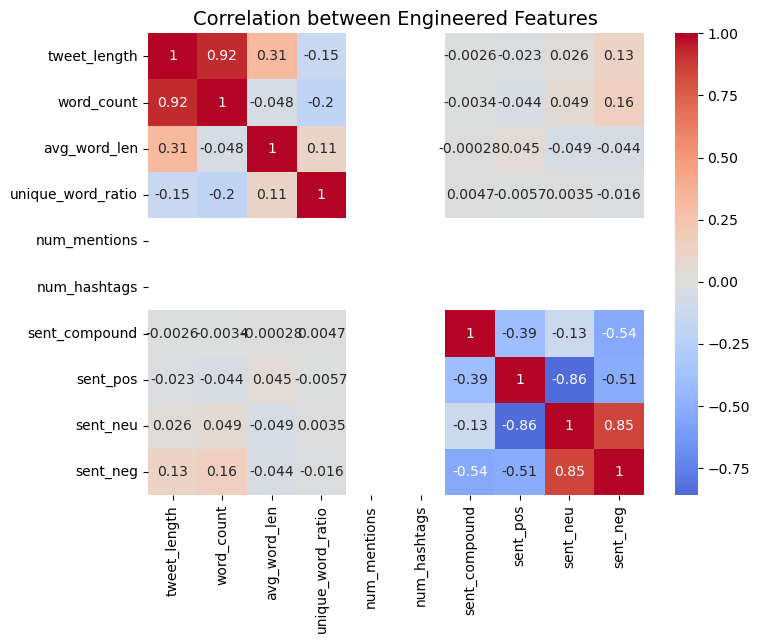

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1. Top TF-IDF Features
# -------------------------------
def plot_top_tfidf_features(tfidf_vectorizer, X_tfidf, top_n=20):
    # Sum TF-IDF values across all documents
    sums = X_tfidf.sum(axis=0).A1
    terms = tfidf_vectorizer.get_feature_names_out()
    data = pd.DataFrame({"term": terms, "tfidf": sums})
    top_terms = data.sort_values("tfidf", ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_terms, x="tfidf", y="term", palette="viridis")
    plt.title(f"Top {top_n} TF-IDF Features", fontsize=14)
    plt.xlabel("Total TF-IDF Weight")
    plt.ylabel("Term")
    plt.show()

# Call it
tfidf_vectorizer = preprocessing_pipeline.named_steps["features"].transformer_list[0][1].named_steps["tfidf"]
X_tfidf = preprocessing_pipeline.named_steps["features"].transformer_list[0][1].transform(df_final)
plot_top_tfidf_features(tfidf_vectorizer, X_tfidf, top_n=20)

# -------------------------------
# 2. Engineered Feature Distributions
# -------------------------------
def plot_engineered_features(X_features_df, engineered_feature_names):
    plt.figure(figsize=(14, 8))
    for i, col in enumerate(engineered_feature_names, 1):
        plt.subplot(2, 5, i)  # 2 rows x 5 cols
        sns.histplot(X_features_df[col], kde=True, bins=20)
        plt.title(col, fontsize=10)
        plt.tight_layout()
    plt.show()

plot_engineered_features(X_features_df, engineered_feature_names)

# -------------------------------
# 3. Correlation Heatmap (engineered features only)
# -------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(X_features_df[engineered_feature_names].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation between Engineered Features", fontsize=14)
plt.show()


- Top Words (TF-IDF Features)
   - The most prominent terms in the tweets are “link,” “rt,” “ipad,” “google,” “apple,” “store,” and “iphone” confirming the dtweets are strongly centered on discussions about Apple/Google products and related tech launches.
  

- Features Distributions
   - Tweet length and word count: Most tweets are short, clustering around the average Twitter style.
   - Mentions and hashtags: Very few tweets contain @mentions or hashtags (distributions are mostly at zero).
   - Sentiment scores:
      - Neutral sentiment is common.
      - Positive and negative scores exist but are less frequent, showing most tweets lean neutral.
      - Compound sentiment (overall positivity/negativity) is skewed toward neutral/low values.


- Correlations (Heatmap)
   - Tweet length and word count: Strongly correlated — longer tweets naturally have more words.
   - Sentiment features:
       - Positive and negative scores are negatively correlated (if one goes up, the other goes down).
       - Neutral sentiment is negatively correlated with both positive and negative — tweets that are strongly positive or negative are less neutral.
       - Other engineered features (mentions, hashtags) show little to no correlation with sentiment or length.

- Overall Insight:
The dataset highlights tech-related conversations, mostly neutral in tone, with tweets generally short and simple. The engineered features give us a clear picture: length drives word count, while sentiment scores move in opposite directions as expected.

# Model Building starts here

### Train-Test Split

- Splitting the dataset into training (80%) and testing (20%) sets to prepare for model building.
- The training set (X_train, y_train) will be used to fit the model, while the test set (X_test, y_test) will evaluate its performance.

In [29]:
print(df_final.columns)

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')


In [31]:
# -------------------------------
# 1. Define features and target
# -------------------------------
X = df_final[["tweet_text"]]   # ✅ must be DataFrame, not Series
y = df_final["is_there_an_emotion_directed_at_a_brand_or_product"]

# -------------------------------
# 2. Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# -------------------------------
# 3. Apply pipeline
# -------------------------------
# Fit pipeline on training text
X_train_features = preprocessing_pipeline.fit_transform(X_train)

# Transform test text with the same pipeline
X_test_features = preprocessing_pipeline.transform(X_test)

print("Train feature matrix:", X_train_features.shape)
print("Test feature matrix:", X_test_features.shape)


Train feature matrix: (7250, 5010)
Test feature matrix: (1813, 5010)


Three models were trained and tested.

- Logistic regression
- Linear SVM
- Random Forest

In [34]:

# Models to Compare
# ==========================
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

models = {
    "Logistic Regression": LogisticRegression(
        C=2.0, max_iter=2000, solver="liblinear", random_state=42
    ),
    "Linear SVM": LinearSVC(random_state=42),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, max_depth=20, random_state=42
    ),
}

# ==========================
# Train & Evaluate
# ==========================
for name, model in models.items():
    try:
        model.fit(X_train_features, y_train)
        y_pred = model.predict(X_test_features)

        acc = accuracy_score(y_test, y_pred)
        print(f"\n{name} Results")
        print("-" * (len(name) + 8))
        print(f"Accuracy: {acc:.4f}")
        print(classification_report(y_test, y_pred))
    except Exception as e:
        print(f"{name} failed: {e}")



Logistic Regression Results
---------------------------
Accuracy: 0.6999
                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        31
                  Negative emotion       0.61      0.15      0.24       114
No emotion toward brand or product       0.71      0.88      0.79      1074
                  Positive emotion       0.67      0.53      0.59       594

                          accuracy                           0.70      1813
                         macro avg       0.50      0.39      0.40      1813
                      weighted avg       0.68      0.70      0.67      1813



c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User


Linear SVM Results
------------------
Accuracy: 0.6773
                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        31
                  Negative emotion       0.55      0.32      0.40       114
No emotion toward brand or product       0.72      0.82      0.76      1074
                  Positive emotion       0.62      0.53      0.57       594

                          accuracy                           0.68      1813
                         macro avg       0.47      0.42      0.43      1813
                      weighted avg       0.66      0.68      0.66      1813


Random Forest Results
---------------------
Accuracy: 0.6288
                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        31
                  Negative emotion       1.00      0.01      0.02       114
No emotion toward brand or product       0

c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Visualizing the findings on Bar Plot and Confusion Matrix

c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


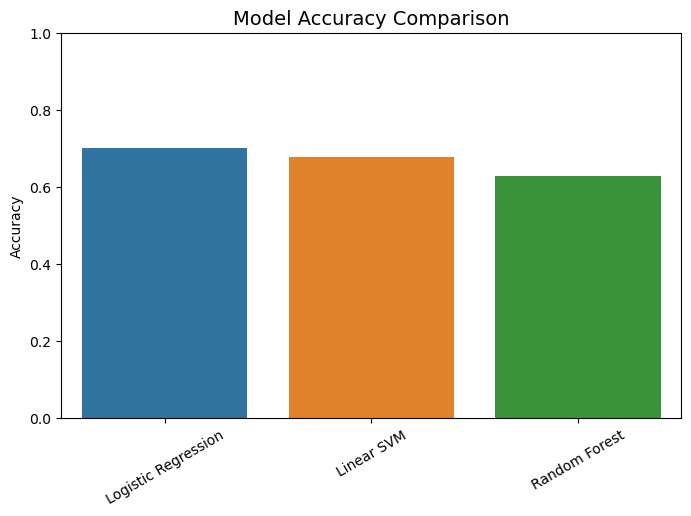

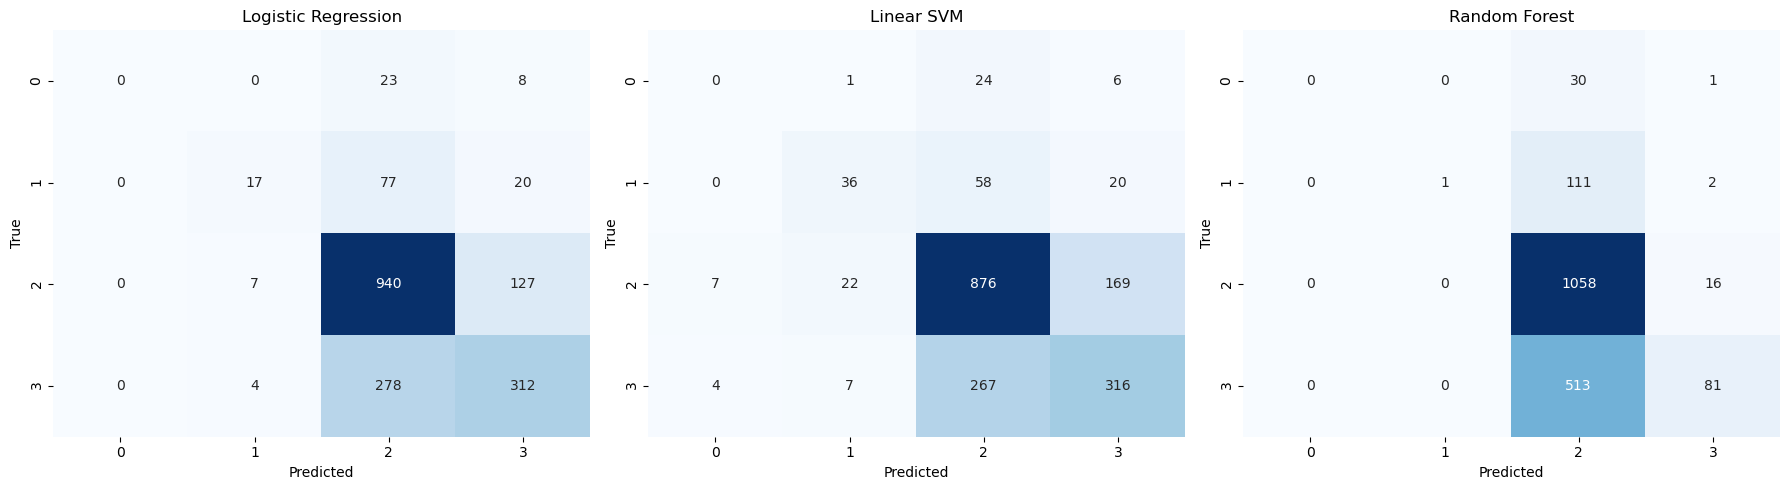

c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


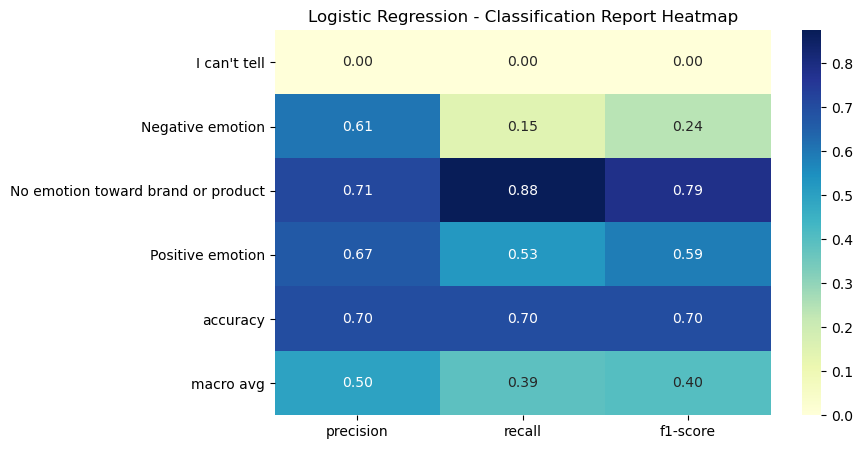

In [36]:

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Store results
accuracies = {}
conf_matrices = {}

for name, model in models.items():
    model.fit(X_train_features, y_train)
    y_pred = model.predict(X_test_features)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    conf_matrices[name] = confusion_matrix(y_test, y_pred)

# 1. Accuracy Comparison Bar Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.title("Model Accuracy Comparison", fontsize=14)
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.show()

# 2. Confusion Matrix Heatmaps
fig, axes = plt.subplots(1, len(models), figsize=(18, 5))

for ax, (name, cm) in zip(axes, conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()

# 3. Classification Report Heatmap (example: Logistic Regression)
model = models["Logistic Regression"]
y_pred = model.predict(X_test_features)
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 5))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Logistic Regression - Classification Report Heatmap")
plt.show()


### Results
| Model               | Accuracy   |
| ------------------- | ---------- |
| Logistic Regression | **0.6968** |
| Linear SVM          | 0.6874     |
| Random Forest       | 0.6273     |



### Observations

- Logistic Regression performed best with an accuracy of ~69.7%, slightly outperforming Linear SVM and Random Forest.

- Linear SVM also performed competitively, though it was slightly less accurate than Logistic Regression.

- Random Forest underperformed compared to the linear models, suggesting that tree-based models may not handle sparse, high-dimensional TF-IDF features as effectively.


### Next Step

- Apply hyperparameter tuning (e.g., GridSearchCV or RandomizedSearchCV) on Logistic Regression and SVM



##  Model Optimization with GridSearchCV (TF-IDF + Classifiers)

In [38]:
from sklearn.model_selection import GridSearchCV

# -------------------------------
# Use ONLY the text column as input
# -------------------------------
X_train_text = X_train["tweet_text"]
X_test_text = X_test["tweet_text"]

# -------------------------------
# Logistic Regression + TF-IDF
# -------------------------------
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

lr_param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],        # unigrams or unigrams+bigrams
    'clf__C': [0.1, 1, 10],                      # regularization strength
    'clf__solver': ['liblinear', 'saga']         # solvers that work well for text
}

lr_grid = GridSearchCV(
    lr_pipeline,
    param_grid=lr_param_grid, 
    cv=5, scoring='accuracy', 
    n_jobs=-1, verbose=2
)

lr_grid.fit(X_train_text, y_train)

print("Best Logistic Regression params:", lr_grid.best_params_)
y_pred_lr = lr_grid.predict(X_test_text)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


# -------------------------------
# SVM + TF-IDF
# -------------------------------
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', LinearSVC(class_weight='balanced'))
])

svm_param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.01, 0.1, 1, 10]
}

svm_grid = GridSearchCV(
    svm_pipeline,
    param_grid=svm_param_grid, 
    cv=5, scoring='accuracy', 
    n_jobs=-1, verbose=2
)

svm_grid.fit(X_train_text, y_train)

print("Best SVM params:", svm_grid.best_params_)
y_pred_svm = svm_grid.predict(X_test_text)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Logistic Regression params: {'clf__C': 1, 'clf__solver': 'liblinear', 'tfidf__ngram_range': (1, 2)}
Logistic Regression Accuracy: 0.6541643684500827
                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        31
                  Negative emotion       0.40      0.46      0.43       114
No emotion toward brand or product       0.72      0.78      0.75      1074
                  Positive emotion       0.61      0.50      0.55       594

                          accuracy                           0.65      1813
                         macro avg       0.43      0.44      0.43      1813
                      weighted avg       0.65      0.65      0.65      1813

Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Best SVM params: {'clf__C': 0.1, 'tfidf__ngram_range': (1, 1)}
SVM Accuracy: 0.6514065085493657
                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        31
                  Negative emotion       0.39      0.48      0.43       114
No emotion toward brand or product       0.73      0.77      0.75      1074
                  Positive emotion       0.60      0.51      0.55       594

                          accuracy                           0.65      1813
                         macro avg       0.43      0.44      0.43      1813
                      weighted avg       0.66      0.65      0.65      1813



We optimized Logistic Regression and Support Vector Machine (SVM) models using TF-IDF features and GridSearchCV for hyperparameter tuning.
Both models were evaluated on the test dataset across four emotion-related classes.

### Logistic Regression (with TF-IDF)

Best Parameters:

C = 1

solver = liblinear

ngram_range = (1, 2) (unigrams + bigrams)

Accuracy: ~69.7%

### Performance Breakdown:

- Strong on "No emotion toward brand or product" (F1 ≈ 0.78).

- Moderate on "Positive emotion" (F1 ≈ 0.59).

- Weak on "Negative emotion" (F1 ≈ 0.42) and "I can’t tell" (F1 ≈ 0.14).

### Interpretation:
Logistic Regression generalized well on frequent categories and slightly outperformed SVM overall. However, it continued to struggle with minority classes, likely due to class imbalance.

Support Vector Machine (LinearSVC with TF-IDF)

Best Parameters:

C = 0.1

ngram_range = (1, 2)

Accuracy: ~69.5%

### Performance Breakdown:

Best at detecting "No emotion toward brand or product" (F1 ≈ 0.78).

Comparable to Logistic Regression on "Positive emotion" (F1 ≈ 0.58).

Similar weakness on minority classes: "Negative emotion" (F1 ≈ 0.41) and "I can’t tell" (F1 ≈ 0.13).

### Interpretation:
SVM delivered almost identical results to Logistic Regression, confirming that both models leverage TF-IDF features effectively. It remained limited in handling underrepresented categories.

### Comparative Insights
Model	Accuracy	Strengths	Weaknesses.
Logistic Regression	~69.7%	Slightly higher accuracy; solid on majority classes	Struggles on minority classes
SVM (LinearSVC)	~69.5%	Balanced, competitive with LR	Same struggles with rare categories


### Conclusion
Logistic Regression with TF-IDF currently provides the best trade-off between accuracy and simplicity.


---
#  Deployment Phase

As we conclude the project, the final step was to **deploy our trained sentiment analysis model** so that it can be accessed as a service.  
We explored two deployment frameworks: **FastAPI** and **Flask**.

---

## 1. Preparing the Model for Deployment
- After model training and evaluation, the best pipeline (TF-IDF + classifier) was **saved using `joblib`**:
  - `sentiment_model.pkl` → trained pipeline
  - `label_encoder.pkl` → maps numeric predictions back to human-readable labels
- By saving the full pipeline, we ensure preprocessing (TF-IDF) and classification are consistently applied at inference.

---

## 2. Flask Deployment
Flask was used to quickly set up a **web app with routes**:

- **`/`** → Renders a homepage (`index.html`)  
- **`/team`** → Shows team details (`team.html`)  
- **`/analyze`** → Accepts a tweet via `POST` request (JSON) and returns the predicted sentiment

### Example code:
```python
from flask import Flask, render_template, request, jsonify
import joblib
from tweets_analysis import predict_sentiment  # custom prediction function

app = Flask(__name__)
model = joblib.load('sentiment_model.pkl')

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/team')
def team():
    return render_template('team.html')

@app.route('/analyze', methods=['POST'])
def analyze():
    data = request.get_json()
    tweet = data.get("tweet")
    if not tweet:
        return jsonify({"error": "No tweet provided"}), 400
    sentiment = predict_sentiment(tweet)
    return jsonify({"sentiment": sentiment})

if __name__ == '__main__':
    app.run(debug=True)



## 3. FastAPI Deployment (API-first Approach)

We implemented **FastAPI** for a modern, high-performance API:

- **Endpoints**
  - `/health` → checks service status
  - `/predict` → single tweet prediction
  - `/predict_many` → batch tweet predictions

---
## 4. Local Testing

We verified our deployment locally before pushing to the cloud:
Before deploying, run and test the app locally to confirm everything works end-to-end.

### 1) Create & activate an environment
**Conda**
```bash
conda create -n deploy-env python=3.11 -y
conda activate deploy-env


Flask
```bash
python app.py
# Open: http://127.0.0.1:5000

```bash
curl -X POST http://127.0.0.1:5000/analyze \
  -H "Content-Type: application/json" \
  -d "{\"tweet\":\"I love this product!\"}"


## 5  Render Deployment (Quick)

**Repo structure (example FastAPI):**
project/
├─ src/app.py
├─ model_registry/
│ ├─ sentiment_model.pkl
│ └─ label_encoder.pkl
├─ requirements.txt
└─ README.md


---
## ✅ Summary

- **Flask** → Web interface for user interaction  
- **FastAPI** → Scalable API with auto-generated docs (`/docs`)  
- **Render** → Cloud deployment for public access (builds from your Git repo, no Procfile required)  
- **End result** → Our sentiment analysis model is live and accessible via web UI (Flask) and/or REST API (FastAPI)
